In [23]:
import json
import pandas as pd
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
%config NotebookApp.iopub_msg_rate_limit=10000
import time
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_score
import numpy as np
import os
os.environ['OMP_NUM_THREADS'] = '4'

In [2]:
with open('mpd.slice.0-999.json', 'r') as json_file:
    playlistData = json.load(json_file)
with open('songs_0-999.json', 'r') as json_file:
    songData = json.load(json_file)
with open('artists_0-999.json', 'r') as json_file:
    artistData = json.load(json_file)
with open('albums_0-999.json', 'r') as json_file:
    albumData = json.load(json_file)

In [3]:
playlistData['playlists'][999]

{'name': 'thinking of you',
 'collaborative': 'false',
 'pid': 999,
 'modified_at': 1507766400,
 'num_tracks': 44,
 'num_albums': 43,
 'num_followers': 1,
 'tracks': [{'pos': 0,
   'artist_name': 'Pvris',
   'track_uri': 'spotify:track:3rUTBx7gmn1IAAwsrjtnO0',
   'artist_uri': 'spotify:artist:6oFs3qk4VepIVFdoD4jmsy',
   'track_name': 'Mind over Matter (Acoustic)',
   'album_uri': 'spotify:album:33oxbqzo7poSO2IbSMqrPS',
   'duration_ms': 203649,
   'album_name': 'Acoustic'},
  {'pos': 1,
   'artist_name': 'Ingrid Michaelson',
   'track_uri': 'spotify:track:6zYqyOJuyXDOvWJwKkZ8tg',
   'artist_uri': 'spotify:artist:2vm8GdHyrJh2O2MfbQFYG0',
   'track_name': 'You and I',
   'album_uri': 'spotify:album:7o2VLivg95UduHjTMTIEIf',
   'duration_ms': 148400,
   'album_name': 'Be OK'},
  {'pos': 2,
   'artist_name': 'Troye Sivan',
   'track_uri': 'spotify:track:0nRuVPZx2iA3KWR4xSzryl',
   'artist_uri': 'spotify:artist:3WGpXCj9YhhfX11TToZcXP',
   'track_name': 'TALK ME DOWN',
   'album_uri': 'spotif

In [4]:
artistData['2wIVse2owClT7go1WT98tk']['genres']

['dance pop',
 'hip hop',
 'hip pop',
 'neo soul',
 'pop rap',
 'r&b',
 'rap',
 'urban contemporary',
 'virginia hip hop']

In [5]:
def findGenresAndArtist(track):
    artist = track['artist_uri']
    artist = artist.split(':')[2]
    if artist in artistData:
        genres = artistData[artist]['genres']
    else:
        genres = []
    return genres, artist

def findModes(lst, n):
    counter = Counter(lst)
    modes = counter.most_common(n)
    return [mode[0] for mode in modes]

def getPlaylistArtists(playlist, modes):
    allArtists = []
    for track in playlist['tracks']:
        artist = track['artist_uri']
        artist = artist.split(':')[2]
        allArtists.append(artist)
    topArtists = findModes(allArtists, modes)
    return topArtists, allArtists
    
def getPlaylistGenres(playlist, modes):
    allGenres = []
    for track in playlist['tracks']:
        genres, a = findGenresAndArtist(track)
        for g in genres:
            allGenres.append(g)
    topGenres = findModes(allGenres, modes)
    return topGenres, allGenres

In [6]:
allGenres = []
allDifGenres = []
allArtists = []
allDifArtists = []
for playlist in playlistData['playlists']:
    for track in playlist['tracks']:
        genres, artist = findGenresAndArtist(track)
        for g in genres:
            allGenres.append(g)
            if not g in allDifGenres:
                allDifGenres.append(g)
        allArtists.append(artist)
        if not artist in allDifArtists:
            allDifArtists.append(artist)

In [7]:
def getFrequency(allList, obj):
    count = 0
    for x in allList:
        if x == obj:
            count += 1
    frequency = round(count/len(allList), 5)
    return frequency

In [8]:
allPlaylistInfo = pd.DataFrame()
counter = 1
for playlist in playlistData['playlists']:
    genres, x = getPlaylistGenres(playlist, 2)
    gfs = []
    for g in genres:
        f = getFrequency(allGenres, g)
        gfs.append(f)
    artists, x = getPlaylistArtists(playlist, 2)
    afs = []
    for a in artists:
        f = getFrequency(allArtists, a)
        afs.append(f)
    row = pd.DataFrame({'playlist': [playlist['pid']],
           'genres': [genres],
           'genreFrequencies_sum':[sum(gfs)],
           'artists': [artists],
           'artistFrequencies_sum':[sum(afs)]})
    allPlaylistInfo = pd.concat([allPlaylistInfo, row], ignore_index=True).reset_index(drop=True)
    percentDone = round((counter/len(playlistData['playlists'])*100),2)
    clear_output(wait=True)
    time.sleep(0.001)
    print(str(percentDone) + "% done")
    counter += 1

100.0% done


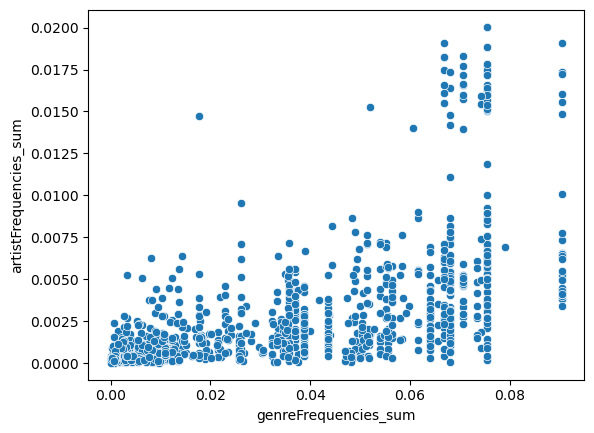

In [9]:
sns.scatterplot(data=allPlaylistInfo, x='genreFrequencies_sum', y='artistFrequencies_sum')
plt.show()

In [10]:
allPlaylistInfo.head()

,playlist,genres,genreFrequencies_sum,artists,artistFrequencies_sum
0,0,"[pop, dance pop]",0.06800,"[2Hjj68yyUPiC0HKEOigcEp, 7bXgB6jMjp9ATFy66eO08Z]",0.00418
1,1,"[rock, album rock]",0.03561,"[2Hkut4rAAyrQxRdof7FVJq, 7zdmbPudNX4SQJXnYIuCTC]",0.00026
2,2,"[k-pop, k-pop boy group]",0.00109,"[3Nrfpe0tUJi4K4DXYWgMUX, 4XDi67ZENZcbfKnvMnTYsI]",0.00072
3,3,"[indie rock, noise pop]",0.00778,"[5juac7bFYyLKmV0VGSyaKM, 2JSc53B5cQ31m0xTB7JFpG]",0.00020
4,4,"[pop rock, permanent wave]",0.01427,"[40Yq4vzPs9VNUrIBG5Jr2i, 2DaxqgrOhkeH0fpeiQq2f4]",0.00099


In [17]:
def miniBatchKMeans(df, k):
    batch_size = 5120
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, random_state=777)
    clusters = minibatch_kmeans.fit_predict(df)
    labels = minibatch_kmeans.fit_predict(df)
    return clusters, labels

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 5120 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 5120 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 5120 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Prog

<AxesSubplot:>

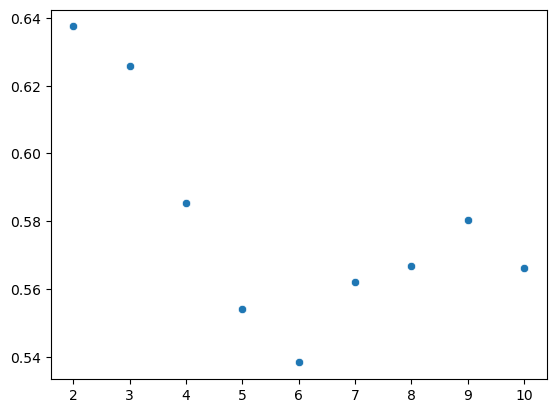

In [18]:
kMeansX = allPlaylistInfo[['genreFrequencies_sum', 'artistFrequencies_sum']]

cluster_range = range(2, 11)

silhouette_scores = {}

for num_clusters in cluster_range:
    clusters, labels = miniBatchKMeans(kMeansX, num_clusters)
    silhouette_scores[num_clusters] = silhouette_score(kMeansX, labels)

sns.scatterplot(x=silhouette_scores.keys(), y=silhouette_scores.values())

In [19]:
clusters, labels = miniBatchKMeans(kMeansX, 4)
kMeansClusters = allPlaylistInfo.copy()
kMeansClusters['cluster'] = clusters

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 5120 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 5120 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [20]:
kMeansClusters.head()

,playlist,genres,genreFrequencies_sum,artists,artistFrequencies_sum,cluster
0,0,"[pop, dance pop]",0.06800,"[2Hjj68yyUPiC0HKEOigcEp, 7bXgB6jMjp9ATFy66eO08Z]",0.00418,2
1,1,"[rock, album rock]",0.03561,"[2Hkut4rAAyrQxRdof7FVJq, 7zdmbPudNX4SQJXnYIuCTC]",0.00026,0
2,2,"[k-pop, k-pop boy group]",0.00109,"[3Nrfpe0tUJi4K4DXYWgMUX, 4XDi67ZENZcbfKnvMnTYsI]",0.00072,1
3,3,"[indie rock, noise pop]",0.00778,"[5juac7bFYyLKmV0VGSyaKM, 2JSc53B5cQ31m0xTB7JFpG]",0.00020,1
4,4,"[pop rock, permanent wave]",0.01427,"[40Yq4vzPs9VNUrIBG5Jr2i, 2DaxqgrOhkeH0fpeiQq2f4]",0.00099,1


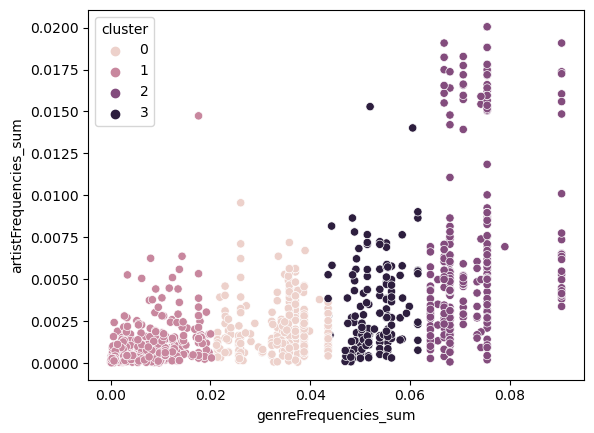

In [21]:
sns.scatterplot(data=kMeansClusters, x='genreFrequencies_sum', y='artistFrequencies_sum', hue='cluster')
plt.show()

In [27]:
meanShiftX = allPlaylistInfo[['genreFrequencies_sum', 'artistFrequencies_sum']]

bandMin = 0.1
bandMax = 0.2
bandStep = 0.01
currentBand = bandMin
scores = {}
while currentBand <= (bandMax+(bandStep/2)):
    ms = MeanShift(bandwidth=currentBand)
    ms.fit(meanShiftX)
    labels = ms.labels_
    if len(set(ms.labels_)) > 1:
        ss_avg = silhouette_score(meanShiftX, labels)
        scores[round(currentBand,1)] = ss_avg
    else:
        scores[round(currentBand,1)] = -5
    percentDone = round(((currentBand-bandMin)/bandStep)/((bandMax-bandMin)/bandStep)*100,2)
    clear_output(wait=True)
    time.sleep(0.001)
    print(str(percentDone) + "% done")
    currentBand += bandStep

100.0% done


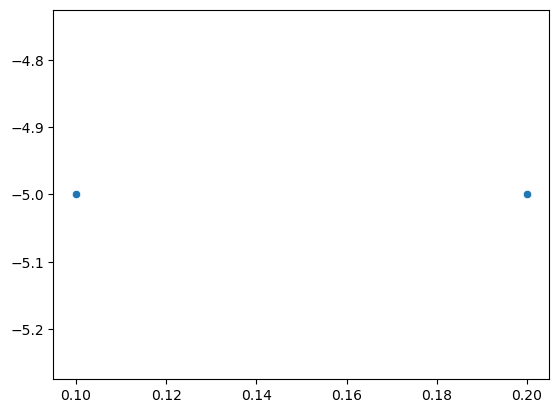

In [28]:
sns.scatterplot(x=scores.keys(), y=scores.values()) #3 is the optimal bandwidth
plt.show()

In [29]:
scores

{0.1: -5, 0.2: -5}